# UNET SEGMENTATION

Arxiv Link: <a href="https://arxiv.org/abs/1505.04597">U-Net: Convolutional Networks for Biomedical Image Segmentation</a>

<ul>
<li>UNet is a fully convolutional network(FCN) that does image segmentation. Its goal is to predict each pixel's class.</li>
 
<li>UNet is built upon the FCN and modified in a way that it yields better segmentation in medical imaging.</li>
</ul>

## 1.1 Architecture

<img src="images/u-net-architecture.png"/>

<h3>UNet Architecture has 3 parts:</h3>
<ol>
    <li>The Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>The Expanding/Upsampling Path</li>
</ol>

<h3>Downsampling Path: </h3> 
<ol>
    <li>It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.</li> 
    <li>At each downsampling step we double the number of feature channels.</li>
</ol>

<h3>Upsampling Path: </h3> 
<ol>
     <li> Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature  map  from  the  downsampling  path,  and  two  3x3  convolutions,  each  followed by a ReLU.</li>
</ol>

<h3> Skip Connection: </h3>
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

<h3> Final Layer: </h3>
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes.

## 1.2 Advantages
<h3> Advantages: </h3>
<ol>
    <li>The UNet combines the location information from the downsampling path to finally obtain a general information combining localisation and context, which is necessary to predict a good segmentation map.</li>
    <li>No Dense layer is used, so image sizes can be used.</li>
</ol>

## 1.3 Dataset
Link: <a href="https://www.kaggle.com/c/data-science-bowl-2018">Data Science Bowl 2018</a>
Find the nuclei in divergent images to advance medical discovery

## 1.4 Code

In [1]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Data Generator

## Hyperparameters

In [3]:
image_size = 128
train_path = "./PycharmProjects/UNet-Segmentation-in-Keras-TensorFlow-master/dataset/stage1_train/"
epochs = 5
batch_size = 8
train_ids = None

if not os.path.exists(train_path):
    print("Change the training path location")

## Training Ids
try:
    train_ids = os.walk(train_path).__next__()[1]
except StopIteration:
    print("Does not exist")
    exit(1)

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [4]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

error: OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [5]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

ValueError: empty range for randrange() (0,0, 0)

## Different Convolutional Blocks

In [39]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [40]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [41]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Training the model

In [42]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/5


 1/82 [..............................] - ETA: 3:08 - loss: 0.6934 - acc: 0.4026

 2/82 [..............................] - ETA: 2:27 - loss: 0.6911 - acc: 0.6219

 3/82 [>.............................] - ETA: 2:08 - loss: 0.6835 - acc: 0.6784

 4/82 [>.............................] - ETA: 2:03 - loss: 0.6582 - acc: 0.7084

 5/82 [>.............................] - ETA: 1:57 - loss: 0.5959 - acc: 0.7536

 6/82 [=>............................] - ETA: 1:49 - loss: 0.6096 - acc: 0.7844

 7/82 [=>............................] - ETA: 1:43 - loss: 0.6813 - acc: 0.7989

 8/82 [=>............................] - ETA: 1:38 - loss: 0.6655 - acc: 0.8079

 9/82 [==>...........................] - ETA: 1:35 - loss: 0.6440 - acc: 0.8214

10/82 [==>...........................] - ETA: 1:31 - loss: 0.6358 - acc: 0.8231

11/82 [===>..........................] - ETA: 1:28 - loss: 0.6324 - acc: 0.8231

12/82 [===>..........................] - ETA: 1:26 - loss: 0.6300 - acc: 0.8311

13/82 [===>..........................] - ETA: 1:23 - loss: 0.6286 - acc: 0.8347

14/82 [====>.........................] - ETA: 1:21 - loss: 0.6276 - acc: 0.8359

15/82 [====>.........................] - ETA: 1:17 - loss: 0.6266 - acc: 0.8368

16/82 [====>.........................] - ETA: 1:14 - loss: 0.6258 - acc: 0.8364

17/82 [=====>........................] - ETA: 1:10 - loss: 0.6211 - acc: 0.8385

18/82 [=====>........................] - ETA: 1:07 - loss: 0.6184 - acc: 0.8388

19/82 [=====>........................] - ETA: 1:05 - loss: 0.6142 - acc: 0.8379

20/82 [======>.......................] - ETA: 1:02 - loss: 0.6102 - acc: 0.8362

21/82 [======>.......................] - ETA: 1:00 - loss: 0.6037 - acc: 0.8360

22/82 [=======>......................] - ETA: 58s - loss: 0.5996 - acc: 0.8353 

23/82 [=======>......................] - ETA: 56s - loss: 0.5833 - acc: 0.8386

24/82 [=======>......................] - ETA: 54s - loss: 0.5735 - acc: 0.8400

25/82 [========>.....................] - ETA: 52s - loss: 0.5754 - acc: 0.8390

26/82 [========>.....................] - ETA: 50s - loss: 0.5631 - acc: 0.8412

27/82 [========>.....................] - ETA: 49s - loss: 0.5580 - acc: 0.8415

28/82 [=========>....................] - ETA: 47s - loss: 0.5473 - acc: 0.8438

29/82 [=========>....................] - ETA: 46s - loss: 0.5405 - acc: 0.8448

30/82 [=========>....................] - ETA: 45s - loss: 0.5370 - acc: 0.8444

31/82 [==========>...................] - ETA: 43s - loss: 0.5342 - acc: 0.8440

32/82 [==========>...................] - ETA: 42s - loss: 0.5287 - acc: 0.8449

33/82 [===========>..................] - ETA: 41s - loss: 0.5205 - acc: 0.8471

34/82 [===========>..................] - ETA: 39s - loss: 0.5156 - acc: 0.8479

35/82 [===========>..................] - ETA: 38s - loss: 0.5111 - acc: 0.8484

36/82 [============>.................] - ETA: 37s - loss: 0.5061 - acc: 0.8491

37/82 [============>.................] - ETA: 36s - loss: 0.5058 - acc: 0.8484

38/82 [============>.................] - ETA: 35s - loss: 0.5045 - acc: 0.8479

39/82 [=============>................] - ETA: 34s - loss: 0.4987 - acc: 0.8491

40/82 [=============>................] - ETA: 33s - loss: 0.4976 - acc: 0.8485

41/82 [==============>...............] - ETA: 32s - loss: 0.4968 - acc: 0.8477

42/82 [==============>...............] - ETA: 31s - loss: 0.4932 - acc: 0.8484

43/82 [==============>...............] - ETA: 30s - loss: 0.4932 - acc: 0.8472

44/82 [===============>..............] - ETA: 29s - loss: 0.4936 - acc: 0.8458

45/82 [===============>..............] - ETA: 28s - loss: 0.4934 - acc: 0.8447

46/82 [===============>..............] - ETA: 27s - loss: 0.4961 - acc: 0.8419

47/82 [================>.............] - ETA: 26s - loss: 0.4956 - acc: 0.8411

48/82 [================>.............] - ETA: 25s - loss: 0.4942 - acc: 0.8413

49/82 [================>.............] - ETA: 24s - loss: 0.4912 - acc: 0.8422

50/82 [=================>............] - ETA: 23s - loss: 0.4890 - acc: 0.8427

51/82 [=================>............] - ETA: 22s - loss: 0.4889 - acc: 0.8416

52/82 [==================>...........] - ETA: 22s - loss: 0.4849 - acc: 0.8426

53/82 [==================>...........] - ETA: 21s - loss: 0.4818 - acc: 0.8432

54/82 [==================>...........] - ETA: 20s - loss: 0.4794 - acc: 0.8433

55/82 [===================>..........] - ETA: 19s - loss: 0.4773 - acc: 0.8431

56/82 [===================>..........] - ETA: 18s - loss: 0.4746 - acc: 0.8433

57/82 [===================>..........] - ETA: 18s - loss: 0.4770 - acc: 0.8417

58/82 [====================>.........] - ETA: 17s - loss: 0.4779 - acc: 0.8402

59/82 [====================>.........] - ETA: 16s - loss: 0.4767 - acc: 0.8403

60/82 [====================>.........] - ETA: 15s - loss: 0.4735 - acc: 0.8410

61/82 [=====================>........] - ETA: 15s - loss: 0.4724 - acc: 0.8406

62/82 [=====================>........] - ETA: 14s - loss: 0.4688 - acc: 0.8417

63/82 [======================>.......] - ETA: 13s - loss: 0.4653 - acc: 0.8427

64/82 [======================>.......] - ETA: 12s - loss: 0.4603 - acc: 0.8442

65/82 [======================>.......] - ETA: 12s - loss: 0.4570 - acc: 0.8446

66/82 [=======================>......] - ETA: 11s - loss: 0.4583 - acc: 0.8437

67/82 [=======================>......] - ETA: 10s - loss: 0.4588 - acc: 0.8425

68/82 [=======================>......] - ETA: 9s - loss: 0.4540 - acc: 0.8437 

69/82 [========================>.....] - ETA: 9s - loss: 0.4513 - acc: 0.8440

70/82 [========================>.....] - ETA: 8s - loss: 0.4478 - acc: 0.8445

71/82 [========================>.....] - ETA: 7s - loss: 0.4443 - acc: 0.8452

72/82 [=========================>....] - ETA: 6s - loss: 0.4418 - acc: 0.8453

73/82 [=========================>....] - ETA: 6s - loss: 0.4383 - acc: 0.8461

74/82 [==========================>...] - ETA: 5s - loss: 0.4390 - acc: 0.8452

75/82 [==========================>...] - ETA: 4s - loss: 0.4368 - acc: 0.8452

76/82 [==========================>...] - ETA: 4s - loss: 0.4356 - acc: 0.8447

77/82 [===========================>..] - ETA: 3s - loss: 0.4368 - acc: 0.8438

78/82 [===========================>..] - ETA: 2s - loss: 0.4351 - acc: 0.8443

79/82 [===========================>..] - ETA: 2s - loss: 0.4331 - acc: 0.8445

80/82 [============================>.] - ETA: 1s - loss: 0.4335 - acc: 0.8436

81/82 [============================>.] - ETA: 0s - loss: 0.4329 - acc: 0.8427

82/82 [==============================] - 56s 683ms/step - loss: 0.4323 - acc: 0.8426 - val_loss: 0.3136 - val_acc: 0.8137


Epoch 2/5


 1/82 [..............................] - ETA: 59s - loss: 0.2433 - acc: 0.8637

 2/82 [..............................] - ETA: 55s - loss: 0.2868 - acc: 0.8460

 3/82 [>.............................] - ETA: 52s - loss: 0.3165 - acc: 0.8313

 4/82 [>.............................] - ETA: 49s - loss: 0.3214 - acc: 0.8298

 5/82 [>.............................] - ETA: 47s - loss: 0.2937 - acc: 0.8459

 6/82 [=>............................] - ETA: 46s - loss: 0.3284 - acc: 0.8349

 7/82 [=>............................] - ETA: 44s - loss: 0.3296 - acc: 0.8313

 8/82 [=>............................] - ETA: 43s - loss: 0.3261 - acc: 0.8334

 9/82 [==>...........................] - ETA: 43s - loss: 0.3079 - acc: 0.8391

10/82 [==>...........................] - ETA: 42s - loss: 0.3065 - acc: 0.8403

11/82 [===>..........................] - ETA: 41s - loss: 0.3090 - acc: 0.8366

12/82 [===>..........................] - ETA: 40s - loss: 0.3003 - acc: 0.8407

13/82 [===>..........................] - ETA: 40s - loss: 0.2962 - acc: 0.8424

14/82 [====>.........................] - ETA: 39s - loss: 0.2903 - acc: 0.8434

15/82 [====>.........................] - ETA: 39s - loss: 0.2817 - acc: 0.8485

16/82 [====>.........................] - ETA: 38s - loss: 0.2963 - acc: 0.8378

17/82 [=====>........................] - ETA: 38s - loss: 0.2880 - acc: 0.8410

18/82 [=====>........................] - ETA: 37s - loss: 0.2934 - acc: 0.8353

19/82 [=====>........................] - ETA: 36s - loss: 0.2966 - acc: 0.8298

20/82 [======>.......................] - ETA: 36s - loss: 0.2966 - acc: 0.8268

21/82 [======>.......................] - ETA: 35s - loss: 0.3018 - acc: 0.8264

22/82 [=======>......................] - ETA: 34s - loss: 0.2991 - acc: 0.8273

23/82 [=======>......................] - ETA: 34s - loss: 0.2938 - acc: 0.8279

24/82 [=======>......................] - ETA: 33s - loss: 0.2943 - acc: 0.8271

25/82 [========>.....................] - ETA: 33s - loss: 0.3012 - acc: 0.8248

26/82 [========>.....................] - ETA: 32s - loss: 0.2979 - acc: 0.8271

27/82 [========>.....................] - ETA: 31s - loss: 0.2945 - acc: 0.8290

28/82 [=========>....................] - ETA: 31s - loss: 0.2933 - acc: 0.8283

29/82 [=========>....................] - ETA: 30s - loss: 0.2909 - acc: 0.8297

30/82 [=========>....................] - ETA: 30s - loss: 0.2832 - acc: 0.8340

31/82 [==========>...................] - ETA: 29s - loss: 0.2771 - acc: 0.8374

32/82 [==========>...................] - ETA: 28s - loss: 0.2762 - acc: 0.8354

33/82 [===========>..................] - ETA: 28s - loss: 0.2761 - acc: 0.8338

34/82 [===========>..................] - ETA: 27s - loss: 0.2724 - acc: 0.8366

35/82 [===========>..................] - ETA: 27s - loss: 0.2677 - acc: 0.8398

36/82 [============>.................] - ETA: 26s - loss: 0.2650 - acc: 0.8410

37/82 [============>.................] - ETA: 25s - loss: 0.2629 - acc: 0.8422

38/82 [============>.................] - ETA: 25s - loss: 0.2666 - acc: 0.8402

39/82 [=============>................] - ETA: 24s - loss: 0.2657 - acc: 0.8407

40/82 [=============>................] - ETA: 24s - loss: 0.2656 - acc: 0.8414

41/82 [==============>...............] - ETA: 23s - loss: 0.2661 - acc: 0.8421

42/82 [==============>...............] - ETA: 23s - loss: 0.2656 - acc: 0.8429

43/82 [==============>...............] - ETA: 22s - loss: 0.2636 - acc: 0.8447

44/82 [===============>..............] - ETA: 21s - loss: 0.2617 - acc: 0.8464

45/82 [===============>..............] - ETA: 21s - loss: 0.2589 - acc: 0.8479

46/82 [===============>..............] - ETA: 20s - loss: 0.2577 - acc: 0.8488

47/82 [================>.............] - ETA: 20s - loss: 0.2584 - acc: 0.8495

48/82 [================>.............] - ETA: 19s - loss: 0.2559 - acc: 0.8511

49/82 [================>.............] - ETA: 19s - loss: 0.2533 - acc: 0.8529

50/82 [=================>............] - ETA: 18s - loss: 0.2506 - acc: 0.8545

51/82 [=================>............] - ETA: 17s - loss: 0.2494 - acc: 0.8552

52/82 [==================>...........] - ETA: 17s - loss: 0.2472 - acc: 0.8564

53/82 [==================>...........] - ETA: 16s - loss: 0.2474 - acc: 0.8553

54/82 [==================>...........] - ETA: 16s - loss: 0.2464 - acc: 0.8564

55/82 [===================>..........] - ETA: 15s - loss: 0.2501 - acc: 0.8553

56/82 [===================>..........] - ETA: 15s - loss: 0.2508 - acc: 0.8553

57/82 [===================>..........] - ETA: 14s - loss: 0.2493 - acc: 0.8561

58/82 [====================>.........] - ETA: 14s - loss: 0.2503 - acc: 0.8559

59/82 [====================>.........] - ETA: 13s - loss: 0.2490 - acc: 0.8568

60/82 [====================>.........] - ETA: 12s - loss: 0.2468 - acc: 0.8580

61/82 [=====================>........] - ETA: 12s - loss: 0.2481 - acc: 0.8569

62/82 [=====================>........] - ETA: 11s - loss: 0.2472 - acc: 0.8580

63/82 [======================>.......] - ETA: 11s - loss: 0.2463 - acc: 0.8590

64/82 [======================>.......] - ETA: 10s - loss: 0.2447 - acc: 0.8604

65/82 [======================>.......] - ETA: 10s - loss: 0.2436 - acc: 0.8611

66/82 [=======================>......] - ETA: 9s - loss: 0.2441 - acc: 0.8610 

67/82 [=======================>......] - ETA: 9s - loss: 0.2441 - acc: 0.8609

68/82 [=======================>......] - ETA: 8s - loss: 0.2412 - acc: 0.8626

69/82 [========================>.....] - ETA: 8s - loss: 0.2393 - acc: 0.8636

70/82 [========================>.....] - ETA: 7s - loss: 0.2379 - acc: 0.8648

71/82 [========================>.....] - ETA: 6s - loss: 0.2379 - acc: 0.8651

72/82 [=========================>....] - ETA: 6s - loss: 0.2373 - acc: 0.8656

73/82 [=========================>....] - ETA: 5s - loss: 0.2368 - acc: 0.8660

74/82 [==========================>...] - ETA: 5s - loss: 0.2349 - acc: 0.8671

75/82 [==========================>...] - ETA: 4s - loss: 0.2330 - acc: 0.8684

76/82 [==========================>...] - ETA: 3s - loss: 0.2322 - acc: 0.8685

77/82 [===========================>..] - ETA: 3s - loss: 0.2308 - acc: 0.8693

78/82 [===========================>..] - ETA: 2s - loss: 0.2297 - acc: 0.8700

79/82 [===========================>..] - ETA: 1s - loss: 0.2294 - acc: 0.8703

80/82 [============================>.] - ETA: 1s - loss: 0.2289 - acc: 0.8707

81/82 [============================>.] - ETA: 0s - loss: 0.2274 - acc: 0.8717

82/82 [==============================] - 55s 671ms/step - loss: 0.2264 - acc: 0.8723 - val_loss: 0.4390 - val_acc: 0.8010


Epoch 3/5


 1/82 [..............................] - ETA: 1:09 - loss: 0.0902 - acc: 0.9563

 2/82 [..............................] - ETA: 1:15 - loss: 0.0951 - acc: 0.9561

 3/82 [>.............................] - ETA: 1:17 - loss: 0.1698 - acc: 0.9182

 4/82 [>.............................] - ETA: 1:24 - loss: 0.1907 - acc: 0.9068

 5/82 [>.............................] - ETA: 1:21 - loss: 0.1855 - acc: 0.9106

 6/82 [=>............................] - ETA: 1:19 - loss: 0.1717 - acc: 0.9162

 7/82 [=>............................] - ETA: 1:16 - loss: 0.1882 - acc: 0.9107

 8/82 [=>............................] - ETA: 1:13 - loss: 0.1816 - acc: 0.9138

 9/82 [==>...........................] - ETA: 1:13 - loss: 0.1810 - acc: 0.9119

10/82 [==>...........................] - ETA: 1:10 - loss: 0.1919 - acc: 0.9051

11/82 [===>..........................] - ETA: 1:08 - loss: 0.2010 - acc: 0.8965

12/82 [===>..........................] - ETA: 1:06 - loss: 0.1960 - acc: 0.8986

13/82 [===>..........................] - ETA: 1:05 - loss: 0.1920 - acc: 0.9001

14/82 [====>.........................] - ETA: 1:03 - loss: 0.1898 - acc: 0.8994

15/82 [====>.........................] - ETA: 1:02 - loss: 0.1872 - acc: 0.9006

16/82 [====>.........................] - ETA: 1:00 - loss: 0.1862 - acc: 0.9018

17/82 [=====>........................] - ETA: 59s - loss: 0.1849 - acc: 0.9014 

18/82 [=====>........................] - ETA: 58s - loss: 0.1901 - acc: 0.8998

19/82 [=====>........................] - ETA: 57s - loss: 0.1887 - acc: 0.8997

20/82 [======>.......................] - ETA: 55s - loss: 0.1893 - acc: 0.8984

21/82 [======>.......................] - ETA: 54s - loss: 0.1882 - acc: 0.8987

22/82 [=======>......................] - ETA: 53s - loss: 0.1903 - acc: 0.8979

23/82 [=======>......................] - ETA: 52s - loss: 0.1862 - acc: 0.9004

24/82 [=======>......................] - ETA: 51s - loss: 0.1839 - acc: 0.9025

25/82 [========>.....................] - ETA: 49s - loss: 0.1859 - acc: 0.9016

26/82 [========>.....................] - ETA: 48s - loss: 0.1847 - acc: 0.9032

27/82 [========>.....................] - ETA: 47s - loss: 0.1824 - acc: 0.9052

28/82 [=========>....................] - ETA: 46s - loss: 0.1838 - acc: 0.9047

29/82 [=========>....................] - ETA: 45s - loss: 0.1838 - acc: 0.9056

30/82 [=========>....................] - ETA: 44s - loss: 0.1814 - acc: 0.9072

31/82 [==========>...................] - ETA: 43s - loss: 0.1830 - acc: 0.9066

32/82 [==========>...................] - ETA: 42s - loss: 0.1819 - acc: 0.9075

33/82 [===========>..................] - ETA: 41s - loss: 0.1794 - acc: 0.9090

34/82 [===========>..................] - ETA: 40s - loss: 0.1833 - acc: 0.9074

35/82 [===========>..................] - ETA: 39s - loss: 0.1827 - acc: 0.9078

36/82 [============>.................] - ETA: 38s - loss: 0.1842 - acc: 0.9072

37/82 [============>.................] - ETA: 37s - loss: 0.1823 - acc: 0.9084

38/82 [============>.................] - ETA: 36s - loss: 0.1855 - acc: 0.9067

39/82 [=============>................] - ETA: 35s - loss: 0.1888 - acc: 0.9055

40/82 [=============>................] - ETA: 34s - loss: 0.1895 - acc: 0.9057

41/82 [==============>...............] - ETA: 33s - loss: 0.1879 - acc: 0.9067

42/82 [==============>...............] - ETA: 32s - loss: 0.1882 - acc: 0.9068

43/82 [==============>...............] - ETA: 32s - loss: 0.1878 - acc: 0.9069

44/82 [===============>..............] - ETA: 31s - loss: 0.1887 - acc: 0.9063

45/82 [===============>..............] - ETA: 30s - loss: 0.1896 - acc: 0.9058

46/82 [===============>..............] - ETA: 29s - loss: 0.1871 - acc: 0.9071

47/82 [================>.............] - ETA: 28s - loss: 0.1859 - acc: 0.9077

48/82 [================>.............] - ETA: 27s - loss: 0.1848 - acc: 0.9085

49/82 [================>.............] - ETA: 26s - loss: 0.1831 - acc: 0.9093

50/82 [=================>............] - ETA: 25s - loss: 0.1806 - acc: 0.9105

51/82 [=================>............] - ETA: 25s - loss: 0.1788 - acc: 0.9112

52/82 [==================>...........] - ETA: 24s - loss: 0.1779 - acc: 0.9118

53/82 [==================>...........] - ETA: 23s - loss: 0.1796 - acc: 0.9118

54/82 [==================>...........] - ETA: 22s - loss: 0.1781 - acc: 0.9127

55/82 [===================>..........] - ETA: 21s - loss: 0.1780 - acc: 0.9128

56/82 [===================>..........] - ETA: 20s - loss: 0.1765 - acc: 0.9136

57/82 [===================>..........] - ETA: 19s - loss: 0.1767 - acc: 0.9134

58/82 [====================>.........] - ETA: 19s - loss: 0.1751 - acc: 0.9142

59/82 [====================>.........] - ETA: 18s - loss: 0.1741 - acc: 0.9148

60/82 [====================>.........] - ETA: 17s - loss: 0.1728 - acc: 0.9155

61/82 [=====================>........] - ETA: 16s - loss: 0.1721 - acc: 0.9158

62/82 [=====================>........] - ETA: 15s - loss: 0.1706 - acc: 0.9165

63/82 [======================>.......] - ETA: 14s - loss: 0.1707 - acc: 0.9163

64/82 [======================>.......] - ETA: 14s - loss: 0.1710 - acc: 0.9160

65/82 [======================>.......] - ETA: 13s - loss: 0.1700 - acc: 0.9164

66/82 [=======================>......] - ETA: 12s - loss: 0.1678 - acc: 0.9174

67/82 [=======================>......] - ETA: 11s - loss: 0.1695 - acc: 0.9167

68/82 [=======================>......] - ETA: 10s - loss: 0.1686 - acc: 0.9172

69/82 [========================>.....] - ETA: 10s - loss: 0.1695 - acc: 0.9166

70/82 [========================>.....] - ETA: 9s - loss: 0.1695 - acc: 0.9166 

71/82 [========================>.....] - ETA: 8s - loss: 0.1679 - acc: 0.9174

72/82 [=========================>....] - ETA: 7s - loss: 0.1666 - acc: 0.9179

73/82 [=========================>....] - ETA: 6s - loss: 0.1661 - acc: 0.9181

74/82 [==========================>...] - ETA: 6s - loss: 0.1663 - acc: 0.9179

75/82 [==========================>...] - ETA: 5s - loss: 0.1658 - acc: 0.9182

76/82 [==========================>...] - ETA: 4s - loss: 0.1648 - acc: 0.9187

77/82 [===========================>..] - ETA: 3s - loss: 0.1639 - acc: 0.9191

78/82 [===========================>..] - ETA: 3s - loss: 0.1646 - acc: 0.9186

79/82 [===========================>..] - ETA: 2s - loss: 0.1655 - acc: 0.9181

80/82 [============================>.] - ETA: 1s - loss: 0.1645 - acc: 0.9185

81/82 [============================>.] - ETA: 0s - loss: 0.1637 - acc: 0.9189

82/82 [==============================] - 63s 764ms/step - loss: 0.1638 - acc: 0.9189 - val_loss: 0.3211 - val_acc: 0.8498


Epoch 4/5


 1/82 [..............................] - ETA: 50s - loss: 0.1991 - acc: 0.9118

 2/82 [..............................] - ETA: 49s - loss: 0.2052 - acc: 0.9053

 3/82 [>.............................] - ETA: 59s - loss: 0.1599 - acc: 0.9282

 4/82 [>.............................] - ETA: 59s - loss: 0.1520 - acc: 0.9328

 5/82 [>.............................] - ETA: 59s - loss: 0.1369 - acc: 0.9401

 6/82 [=>............................] - ETA: 58s - loss: 0.1592 - acc: 0.9257

 7/82 [=>............................] - ETA: 56s - loss: 0.1619 - acc: 0.9243

 8/82 [=>............................] - ETA: 54s - loss: 0.1599 - acc: 0.9243

 9/82 [==>...........................] - ETA: 53s - loss: 0.1540 - acc: 0.9281

10/82 [==>...........................] - ETA: 53s - loss: 0.1542 - acc: 0.9262

11/82 [===>..........................] - ETA: 52s - loss: 0.1468 - acc: 0.9306

12/82 [===>..........................] - ETA: 50s - loss: 0.1385 - acc: 0.9343

13/82 [===>..........................] - ETA: 49s - loss: 0.1402 - acc: 0.9332

14/82 [====>.........................] - ETA: 48s - loss: 0.1401 - acc: 0.9322

15/82 [====>.........................] - ETA: 47s - loss: 0.1509 - acc: 0.9274

16/82 [====>.........................] - ETA: 46s - loss: 0.1515 - acc: 0.9269

17/82 [=====>........................] - ETA: 45s - loss: 0.1468 - acc: 0.9290

18/82 [=====>........................] - ETA: 44s - loss: 0.1475 - acc: 0.9285

19/82 [=====>........................] - ETA: 43s - loss: 0.1456 - acc: 0.9290

20/82 [======>.......................] - ETA: 42s - loss: 0.1399 - acc: 0.9317

21/82 [======>.......................] - ETA: 41s - loss: 0.1391 - acc: 0.9324

22/82 [=======>......................] - ETA: 41s - loss: 0.1384 - acc: 0.9325

23/82 [=======>......................] - ETA: 40s - loss: 0.1371 - acc: 0.9329

24/82 [=======>......................] - ETA: 39s - loss: 0.1357 - acc: 0.9337

25/82 [========>.....................] - ETA: 39s - loss: 0.1360 - acc: 0.9335

26/82 [========>.....................] - ETA: 38s - loss: 0.1345 - acc: 0.9338

27/82 [========>.....................] - ETA: 37s - loss: 0.1324 - acc: 0.9350

28/82 [=========>....................] - ETA: 36s - loss: 0.1313 - acc: 0.9352

29/82 [=========>....................] - ETA: 36s - loss: 0.1305 - acc: 0.9355

30/82 [=========>....................] - ETA: 35s - loss: 0.1269 - acc: 0.9371

31/82 [==========>...................] - ETA: 34s - loss: 0.1247 - acc: 0.9380

32/82 [==========>...................] - ETA: 34s - loss: 0.1265 - acc: 0.9370

33/82 [===========>..................] - ETA: 33s - loss: 0.1278 - acc: 0.9362

34/82 [===========>..................] - ETA: 32s - loss: 0.1275 - acc: 0.9362

35/82 [===========>..................] - ETA: 31s - loss: 0.1286 - acc: 0.9357

36/82 [============>.................] - ETA: 30s - loss: 0.1290 - acc: 0.9357

37/82 [============>.................] - ETA: 30s - loss: 0.1298 - acc: 0.9351

38/82 [============>.................] - ETA: 29s - loss: 0.1326 - acc: 0.9338

39/82 [=============>................] - ETA: 28s - loss: 0.1307 - acc: 0.9347

40/82 [=============>................] - ETA: 28s - loss: 0.1304 - acc: 0.9351

41/82 [==============>...............] - ETA: 27s - loss: 0.1290 - acc: 0.9359

42/82 [==============>...............] - ETA: 26s - loss: 0.1302 - acc: 0.9351

43/82 [==============>...............] - ETA: 25s - loss: 0.1288 - acc: 0.9358

44/82 [===============>..............] - ETA: 25s - loss: 0.1302 - acc: 0.9354

45/82 [===============>..............] - ETA: 24s - loss: 0.1308 - acc: 0.9351

46/82 [===============>..............] - ETA: 23s - loss: 0.1331 - acc: 0.9341

47/82 [================>.............] - ETA: 22s - loss: 0.1339 - acc: 0.9338

48/82 [================>.............] - ETA: 22s - loss: 0.1328 - acc: 0.9344

49/82 [================>.............] - ETA: 21s - loss: 0.1327 - acc: 0.9344

50/82 [=================>............] - ETA: 20s - loss: 0.1320 - acc: 0.9345

51/82 [=================>............] - ETA: 20s - loss: 0.1314 - acc: 0.9349

52/82 [==================>...........] - ETA: 19s - loss: 0.1304 - acc: 0.9353

53/82 [==================>...........] - ETA: 18s - loss: 0.1297 - acc: 0.9355

54/82 [==================>...........] - ETA: 18s - loss: 0.1281 - acc: 0.9363

55/82 [===================>..........] - ETA: 17s - loss: 0.1275 - acc: 0.9366

56/82 [===================>..........] - ETA: 16s - loss: 0.1272 - acc: 0.9368

57/82 [===================>..........] - ETA: 16s - loss: 0.1264 - acc: 0.9372

58/82 [====================>.........] - ETA: 15s - loss: 0.1257 - acc: 0.9374

59/82 [====================>.........] - ETA: 14s - loss: 0.1248 - acc: 0.9378

60/82 [====================>.........] - ETA: 14s - loss: 0.1247 - acc: 0.9377

61/82 [=====================>........] - ETA: 13s - loss: 0.1248 - acc: 0.9376

62/82 [=====================>........] - ETA: 12s - loss: 0.1283 - acc: 0.9361

63/82 [======================>.......] - ETA: 12s - loss: 0.1287 - acc: 0.9358

64/82 [======================>.......] - ETA: 11s - loss: 0.1282 - acc: 0.9361

65/82 [======================>.......] - ETA: 10s - loss: 0.1284 - acc: 0.9360

66/82 [=======================>......] - ETA: 10s - loss: 0.1295 - acc: 0.9353

67/82 [=======================>......] - ETA: 9s - loss: 0.1289 - acc: 0.9356 

68/82 [=======================>......] - ETA: 9s - loss: 0.1287 - acc: 0.9357

69/82 [========================>.....] - ETA: 8s - loss: 0.1284 - acc: 0.9359

70/82 [========================>.....] - ETA: 7s - loss: 0.1280 - acc: 0.9360

71/82 [========================>.....] - ETA: 7s - loss: 0.1300 - acc: 0.9353

72/82 [=========================>....] - ETA: 6s - loss: 0.1290 - acc: 0.9358

73/82 [=========================>....] - ETA: 5s - loss: 0.1288 - acc: 0.9358

74/82 [==========================>...] - ETA: 5s - loss: 0.1288 - acc: 0.9358

75/82 [==========================>...] - ETA: 4s - loss: 0.1284 - acc: 0.9360

76/82 [==========================>...] - ETA: 3s - loss: 0.1281 - acc: 0.9361

77/82 [===========================>..] - ETA: 3s - loss: 0.1290 - acc: 0.9358

78/82 [===========================>..] - ETA: 2s - loss: 0.1287 - acc: 0.9358

79/82 [===========================>..] - ETA: 1s - loss: 0.1287 - acc: 0.9359

80/82 [============================>.] - ETA: 1s - loss: 0.1279 - acc: 0.9364

81/82 [============================>.] - ETA: 0s - loss: 0.1270 - acc: 0.9367

82/82 [==============================] - 53s 640ms/step - loss: 0.1269 - acc: 0.9367 - val_loss: 0.1815 - val_acc: 0.9037


Epoch 5/5


 1/82 [..............................] - ETA: 54s - loss: 0.0515 - acc: 0.9771

 2/82 [..............................] - ETA: 49s - loss: 0.1065 - acc: 0.9447

 3/82 [>.............................] - ETA: 47s - loss: 0.1369 - acc: 0.9302

 4/82 [>.............................] - ETA: 48s - loss: 0.1446 - acc: 0.9253

 5/82 [>.............................] - ETA: 49s - loss: 0.1303 - acc: 0.9324

 6/82 [=>............................] - ETA: 50s - loss: 0.1233 - acc: 0.9364

 7/82 [=>............................] - ETA: 51s - loss: 0.1206 - acc: 0.9370

 8/82 [=>............................] - ETA: 50s - loss: 0.1156 - acc: 0.9395

 9/82 [==>...........................] - ETA: 49s - loss: 0.1104 - acc: 0.9420

10/82 [==>...........................] - ETA: 48s - loss: 0.1168 - acc: 0.9404

11/82 [===>..........................] - ETA: 47s - loss: 0.1154 - acc: 0.9410

12/82 [===>..........................] - ETA: 45s - loss: 0.1206 - acc: 0.9380

13/82 [===>..........................] - ETA: 44s - loss: 0.1192 - acc: 0.9381

14/82 [====>.........................] - ETA: 43s - loss: 0.1152 - acc: 0.9399

15/82 [====>.........................] - ETA: 42s - loss: 0.1124 - acc: 0.9412

16/82 [====>.........................] - ETA: 41s - loss: 0.1128 - acc: 0.9412

17/82 [=====>........................] - ETA: 41s - loss: 0.1204 - acc: 0.9365

18/82 [=====>........................] - ETA: 40s - loss: 0.1173 - acc: 0.9381

19/82 [=====>........................] - ETA: 39s - loss: 0.1167 - acc: 0.9386

20/82 [======>.......................] - ETA: 39s - loss: 0.1177 - acc: 0.9379

21/82 [======>.......................] - ETA: 38s - loss: 0.1157 - acc: 0.9392

22/82 [=======>......................] - ETA: 37s - loss: 0.1127 - acc: 0.9407

23/82 [=======>......................] - ETA: 36s - loss: 0.1134 - acc: 0.9410

24/82 [=======>......................] - ETA: 36s - loss: 0.1122 - acc: 0.9415

25/82 [========>.....................] - ETA: 35s - loss: 0.1099 - acc: 0.9428

26/82 [========>.....................] - ETA: 35s - loss: 0.1116 - acc: 0.9417

27/82 [========>.....................] - ETA: 34s - loss: 0.1087 - acc: 0.9432

28/82 [=========>....................] - ETA: 33s - loss: 0.1069 - acc: 0.9443

29/82 [=========>....................] - ETA: 32s - loss: 0.1081 - acc: 0.9437

30/82 [=========>....................] - ETA: 32s - loss: 0.1066 - acc: 0.9446

31/82 [==========>...................] - ETA: 31s - loss: 0.1083 - acc: 0.9434

32/82 [==========>...................] - ETA: 31s - loss: 0.1079 - acc: 0.9434

33/82 [===========>..................] - ETA: 30s - loss: 0.1077 - acc: 0.9432

34/82 [===========>..................] - ETA: 29s - loss: 0.1085 - acc: 0.9428

35/82 [===========>..................] - ETA: 29s - loss: 0.1097 - acc: 0.9421

36/82 [============>.................] - ETA: 28s - loss: 0.1091 - acc: 0.9422

37/82 [============>.................] - ETA: 27s - loss: 0.1070 - acc: 0.9433

38/82 [============>.................] - ETA: 26s - loss: 0.1091 - acc: 0.9422

39/82 [=============>................] - ETA: 26s - loss: 0.1135 - acc: 0.9401

40/82 [=============>................] - ETA: 25s - loss: 0.1147 - acc: 0.9395

41/82 [==============>...............] - ETA: 25s - loss: 0.1139 - acc: 0.9399

42/82 [==============>...............] - ETA: 24s - loss: 0.1155 - acc: 0.9386

43/82 [==============>...............] - ETA: 23s - loss: 0.1151 - acc: 0.9387

44/82 [===============>..............] - ETA: 23s - loss: 0.1137 - acc: 0.9396

45/82 [===============>..............] - ETA: 22s - loss: 0.1136 - acc: 0.9399

46/82 [===============>..............] - ETA: 21s - loss: 0.1134 - acc: 0.9400

47/82 [================>.............] - ETA: 21s - loss: 0.1125 - acc: 0.9406

48/82 [================>.............] - ETA: 20s - loss: 0.1116 - acc: 0.9412

49/82 [================>.............] - ETA: 20s - loss: 0.1123 - acc: 0.9412

50/82 [=================>............] - ETA: 19s - loss: 0.1125 - acc: 0.9410

51/82 [=================>............] - ETA: 18s - loss: 0.1131 - acc: 0.9407

52/82 [==================>...........] - ETA: 18s - loss: 0.1166 - acc: 0.9396

53/82 [==================>...........] - ETA: 17s - loss: 0.1163 - acc: 0.9397

54/82 [==================>...........] - ETA: 16s - loss: 0.1176 - acc: 0.9393

55/82 [===================>..........] - ETA: 16s - loss: 0.1182 - acc: 0.9390

56/82 [===================>..........] - ETA: 15s - loss: 0.1191 - acc: 0.9384

57/82 [===================>..........] - ETA: 15s - loss: 0.1208 - acc: 0.9378

58/82 [====================>.........] - ETA: 14s - loss: 0.1234 - acc: 0.9365

59/82 [====================>.........] - ETA: 13s - loss: 0.1242 - acc: 0.9362

60/82 [====================>.........] - ETA: 13s - loss: 0.1243 - acc: 0.9362

61/82 [=====================>........] - ETA: 12s - loss: 0.1237 - acc: 0.9364

62/82 [=====================>........] - ETA: 12s - loss: 0.1227 - acc: 0.9369

63/82 [======================>.......] - ETA: 11s - loss: 0.1267 - acc: 0.9356

64/82 [======================>.......] - ETA: 10s - loss: 0.1270 - acc: 0.9355

65/82 [======================>.......] - ETA: 10s - loss: 0.1264 - acc: 0.9357

66/82 [=======================>......] - ETA: 9s - loss: 0.1269 - acc: 0.9355 

67/82 [=======================>......] - ETA: 9s - loss: 0.1265 - acc: 0.9358

68/82 [=======================>......] - ETA: 8s - loss: 0.1273 - acc: 0.9354

69/82 [========================>.....] - ETA: 7s - loss: 0.1279 - acc: 0.9351

70/82 [========================>.....] - ETA: 7s - loss: 0.1282 - acc: 0.9348

71/82 [========================>.....] - ETA: 6s - loss: 0.1289 - acc: 0.9344

72/82 [=========================>....] - ETA: 6s - loss: 0.1292 - acc: 0.9342

73/82 [=========================>....] - ETA: 5s - loss: 0.1296 - acc: 0.9340

74/82 [==========================>...] - ETA: 4s - loss: 0.1303 - acc: 0.9337

75/82 [==========================>...] - ETA: 4s - loss: 0.1298 - acc: 0.9338

76/82 [==========================>...] - ETA: 3s - loss: 0.1304 - acc: 0.9335

77/82 [===========================>..] - ETA: 2s - loss: 0.1291 - acc: 0.9342

78/82 [===========================>..] - ETA: 2s - loss: 0.1283 - acc: 0.9345

79/82 [===========================>..] - ETA: 1s - loss: 0.1281 - acc: 0.9346

80/82 [============================>.] - ETA: 1s - loss: 0.1293 - acc: 0.9341

81/82 [============================>.] - ETA: 0s - loss: 0.1285 - acc: 0.9344

82/82 [==============================] - 49s 595ms/step - loss: 0.1287 - acc: 0.9344 - val_loss: 0.1690 - val_acc: 0.9116


## Testing the model

In [44]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

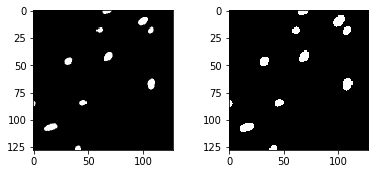

In [45]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

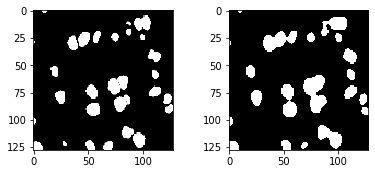

In [46]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")